In [1]:
using Revise

In [2]:
using RigidBodyDynamics
const rbd = RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using Plots; gr()
using Statistics
using LightXML
using StaticArrays
using Optim
using LinearAlgebra

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2960f7a9470cccbd9720b97d445136403985fc81-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2960f7a9470cccbd9720b97d445136403985fc81-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [ ]:
vis = Visualizer()

In [ ]:
# open(vis)

In [46]:
"""
Parse the Drake-specific `loop_joint` tags from a URDF and use them
to add non-tree joints to the given mechanism.
"""
function add_loop_joints!(mechanism::Mechanism{T}, urdf::AbstractString) where T
    doc = parse_file(urdf)
    xml_root = LightXML.root(doc)
    xml_loops = get_elements_by_tagname(xml_root, "loop_joint")
    for xml_loop in xml_loops
        name = attribute(xml_loop, "name")
        @assert attribute(xml_loop, "type") == "continuous"
        axis = SVector{3}(rbd.parse_vector(T, find_element(xml_loop, "axis"), "xyz", "1 0 0"))
        joint = Joint(name, Revolute(axis))
        xml_link1 = find_element(xml_loop, "link1")
        body1 = findbody(mechanism, attribute(xml_link1, "link"))
        H1 = Transform3D(frame_before(joint), default_frame(body1),
            rbd.parse_pose(T, xml_link1)...)
        xml_link2 = find_element(xml_loop, "link2")
        body2 = findbody(mechanism, attribute(xml_link2, "link"))
        H2 = Transform3D(frame_after(joint), default_frame(body2),
            rbd.parse_pose(T, xml_link2)...)
        attach!(mechanism, body1, body2, joint,
            joint_pose = H1,
            successor_pose = inv(H2))
    end
end         

add_loop_joints! (generic function with 1 method)

In [190]:
"""
Return a function which maps a configuration vector
for the given mechanism to the total squared error in
the alignment of the robot's non-tree joints.
"""
function loop_joint_error(mechanism)
    # For each non-tree joint, compute a pair of Point3Ds, 
    # where each point in the pair represents the position
    # of the non-tree joint in the frame of the predecessor
    # or successor (respectively) of that joint. When the 
    # non-tree joints are perfectly aligned, the two points
    # in each pair will lie at the same position in world frame.
    # 
    # This assumes that the non-tree joints are all Revolute.
    pinned_points = map(rbd.non_tree_joints(mechanism)) do joint
        H1 = joint.joint_to_predecessor[]
        H2 = joint.joint_to_successor[]
        (H1 * Point3D(H1.from, 0., 0, 0),
         H2 * Point3D(H2.from, 0., 0, 0))
    end
    
    let cache = StateCache(robot), points = pinned_points
        function(x)
            state = cache[eltype(x)]
            set_configuration!(state, x)
            sum(points) do (p1, p2)
                offset = (transform(state, p1, root_frame(state.mechanism)) -
                          transform(state, p2, root_frame(state.mechanism)))
                err = sum(abs2, offset.v)
            end
        end
    end
end

loop_joint_error

In [200]:
urdf = "data/Strandbeest.urdf"
robot = parse_urdf(Float64, urdf)
add_loop_joints!(robot, urdf)
mvis = MechanismVisualizer(robot, URDFVisuals(urdf), vis)

MechanismVisualizer{MechanismState{Float64,Float64,Float64,TypeSortedCollections.TypeSortedCollection{Tuple{Array{Joint{Float64,Fixed{Float64}},1},Array{Joint{Float64,Revolute{Float64}},1}},2}},Visualizer}(MechanismState{Float64, Float64, Float64, …}(…), MeshCat Visualizer with path /meshcat, 134)

In [201]:
# Find an initial state of the robot which correctly aligns all 
# the loop joints.

# First, initialize the state with a configuration within the 
# joint limits:
bounds = collect(Iterators.flatten(rbd.position_bounds.(tree_joints(robot))))
lb = rbd.lower.(bounds)
ub = rbd.upper.(bounds);
state = MechanismState(robot)
set_configuration!(state, clamp.(configuration(state), lb, ub))

# Use Optim's Fminbox to minimize the loop joint error within
# the joint limits:
cost = loop_joint_error(robot)
result = Optim.optimize(cost, lb, ub, 
    Vector(configuration(state)), 
    Fminbox(LBFGS()), autodiff=:forward)

# Verify that we've actually closed all the loops
@assert Optim.minimum(result) < 1e-9

# Visualize the result
set_configuration!(state, Optim.minimizer(result))
copyto!(mvis, state)

┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 47, 48, 50, 51, 53, 54, 56, 57, 59, 60, 62, 63, 65, 66, 68, 69, 71, 72]
└ @ Optim /home/rdeits/.julia/dev/Optim/src/multivariate/solvers/constrained/fminbox.jl:212


In [199]:
# Simulate the robot

# Our controller will try to drive the central crank shaft
# to a constant speed of 1 radian per second:
controller = function (τ, t, state)
    any(isnan, configuration(state)) && error("NaN at time: $t")
    τ .= 0
    τ[2] = -10.0 * (velocity(state)[2] - 1.0)
end

# Simulate for 4 seconds
ts, qs, vs = rbd.simulate(state, 4.0, controller; Δt=1e-3)

# Animate the result
setanimation!(mvis, ts, qs)

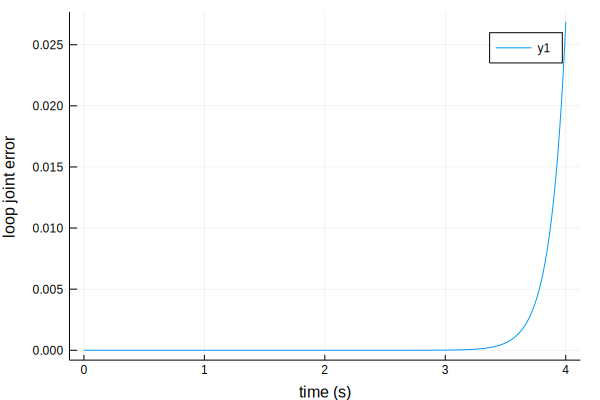

In [202]:
# Plot the loop joint error over time
plot(ts, cost.(qs), xlabel="time (s)", ylabel="loop joint error")